# FE Stats Classifier Model Analysis

In [1]:
# [FE_Stats_Data_Analysis]: Need to include path to the singleton pattern impl due to a dependency from the CharacterStatsAnalysis class
# Note: The directory is based of the current working dir of the notebook since the class base directory changes to this one
import sys, os

sys.path.append(os.path.abspath('src/Singleton'))

import torch
import torch.utils.data as torch_data
from src.Models.FEMLPClassifier import FEMLPClassifier
import src.Models.ModelAnalysis as ma
from src.Models.StatsDataset import StatsDataset

torch.manual_seed(42)

accel_device = "cuda:0"

dtype = torch.float32

batch_size = 4

num_epochs = 100


In [2]:
stats_dataset = StatsDataset(accel_device, dtype)
train_dataset, test_dataset = torch_data.random_split(stats_dataset, [0.8, 0.2])
train_dataset, val_dataset = torch_data.random_split(train_dataset, [0.8, 0.2])
train_dataloader = torch_data.DataLoader(train_dataset, batch_size, True)

val_dataloader = torch_data.DataLoader(val_dataset, batch_size, True)

test_dataloader = torch_data.DataLoader(test_dataset, len(test_dataset))


### **Multilayered Perceptron (MLP) Classifier**

In [3]:
num_features = stats_dataset.stats_data[:, :-1].shape[1]
num_classes = stats_dataset.stats_data[:, -1].unique().shape[0]

baseline_sgd_config = { "optim_name":"SGD","lr":0.001,"weight_decay":1e-6 }


#### Balanced Complexity

In [4]:
baslanced_mlp_classifier = FEMLPClassifier(num_features * 3, 3, num_features, num_classes, accel_device, dtype)


In [5]:
balanced_mlp_history = ma.run_train_forward_pytorch(baslanced_mlp_classifier, train_dataloader, val_dataloader, num_epochs, baseline_sgd_config, accel_device, dtype)


[INFO] Epoch 1/100: Train/Validation loss = 2.2011/2.3517, train/validation accuracy = 12.50%/25.00%

[INFO] Epoch 2/100: Train/Validation loss = 2.1762/2.3302, train/validation accuracy = 18.75%/25.00%

[INFO] Epoch 3/100: Train/Validation loss = 2.1584/2.3143, train/validation accuracy = 18.75%/0.00%

[INFO] Epoch 4/100: Train/Validation loss = 2.1424/2.3026, train/validation accuracy = 18.75%/0.00%

[INFO] Epoch 5/100: Train/Validation loss = 2.1316/2.2934, train/validation accuracy = 18.75%/0.00%

[INFO] Epoch 6/100: Train/Validation loss = 2.1118/2.2885, train/validation accuracy = 25.00%/0.00%

[INFO] Epoch 7/100: Train/Validation loss = 2.1000/2.2856, train/validation accuracy = 25.00%/0.00%

[INFO] Epoch 8/100: Train/Validation loss = 2.0989/2.2853, train/validation accuracy = 25.00%/0.00%

[INFO] Epoch 9/100: Train/Validation loss = 2.0813/2.2846, train/validation accuracy = 25.00%/0.00%

[INFO] Epoch 10/100: Train/Validation loss = 2.0721/2.2854, train/validation accuracy = 2

In [6]:
balanced_mlp_history.keys()


dict_keys(['train_losses', 'train_accs', 'val_losses', 'val_accs'])

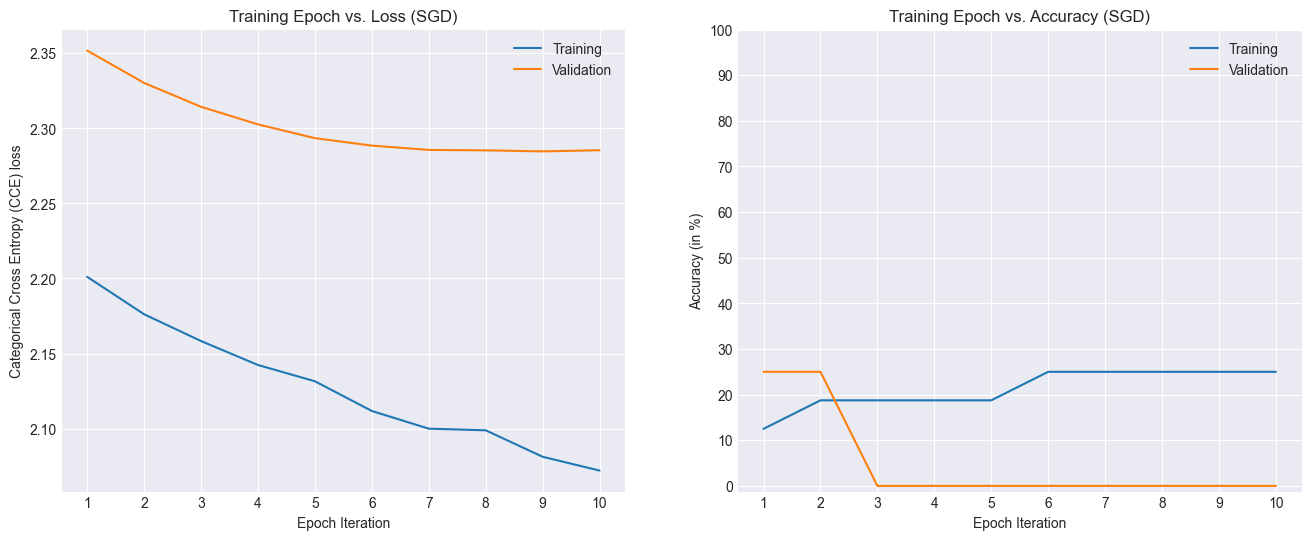

In [7]:
ma.show_analysis_charts(balanced_mlp_history["train_losses"], balanced_mlp_history["train_accs"], balanced_mlp_history["val_losses"], balanced_mlp_history["val_accs"])
